# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

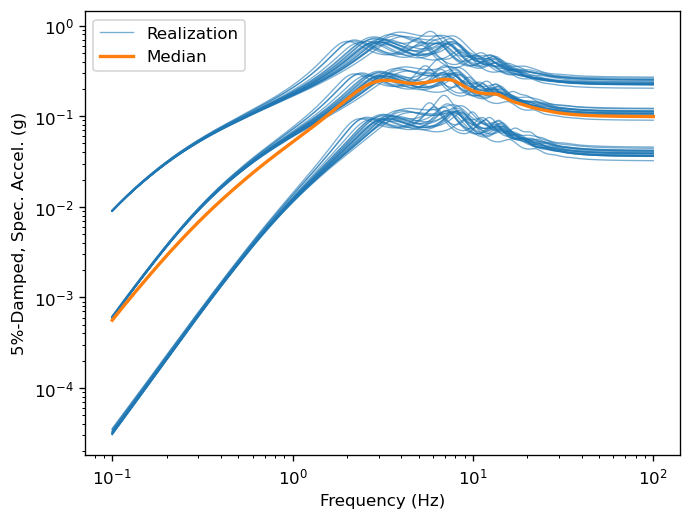

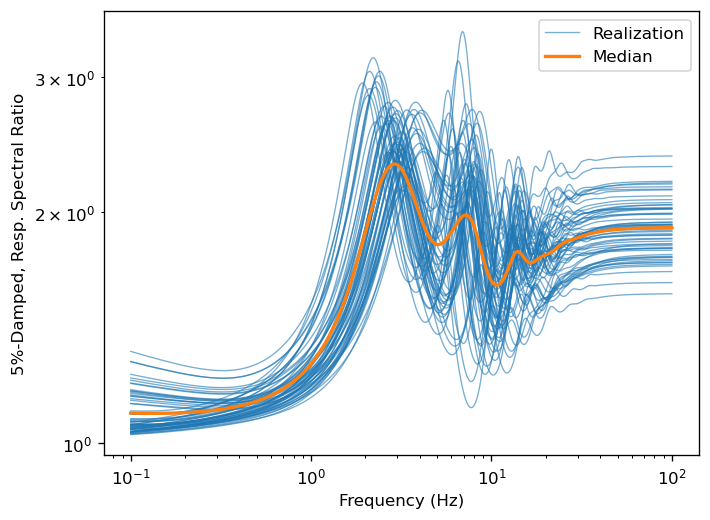

In [9]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

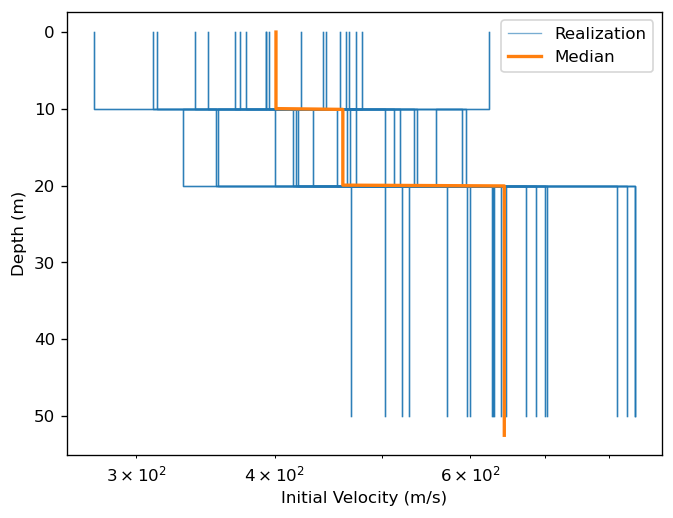

In [10]:
ax = outputs[-1].plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [11]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.216006  1.074398  1.048169  1.316882  1.101803  1.063486   
0.101394    1.215298  1.074341  1.048538  1.315609  1.101693  1.063957   
0.102807    1.214593  1.074290  1.048911  1.314341  1.101589  1.064433   
0.104240    1.213890  1.074244  1.049287  1.313076  1.101492  1.064915   
0.105693    1.213190  1.074203  1.049668  1.311816  1.101402  1.065402   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.366644  2.193111  2.017384  2.183667  2.043486  1.818887   
95.932095   2.366709  2.193179  2.017491  2.183767  2.043596  1.819020   
97.269336   2.366772  2.193245  2.017595  2.183864  2.043702  1.819150   
98.625218   2.366833  2.193308  2.017695  2.183958  2.043805  1.819275   
100.000000  2.366892  2.193370  2.017793  2.184049  2.043906  1.819397   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.137302  1.046699  1.028656  1.126093  ...  1.036289  1.277502   
0.101394    1.136903  1.046679  1.028886  1.125721  ...  1.036575  1.276435   
0.102807    1.136505  1.046663  1.029119  1.125351  ...  1.036864  1.275373   
0.104240    1.136109  1.046652  1.029354  1.124982  ...  1.037156  1.274313   
0.105693    1.135714  1.046644  1.029592  1.124614  ...  1.037451  1.273258   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.865314  1.783897  1.718030  1.673074  ...  1.701799  2.021262   
95.932095   1.865352  1.783924  1.718070  1.673127  ...  1.701862  2.021360   
97.269336   1.865388  1.783950  1.718108  1.673178  ...  1.701923  2.021455   
98.625218   1.865423  1.783975  1.718145  1.673228  ...  1.701983  2.021548   
100.000000  1.865457  1.784000  1.718182  1.673276  ...  1.702040  2.021638   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.091166  1.057563  1.197950  1.067713  1.042832  1.229444   
0.101394    1.091075  1.057994  1.197310  1.067666  1.043164  1.228606   
0.102807    1.090990  1.058430  1.196673  1.067623  1.043500  1.227771   
0.104240    1.090912  1.058870  1.196038  1.067586  1.043839  1.226939   
0.105693    1.090840  1.059315  1.195405  1.067554  1.044182  1.226111   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.923817  1.746161  2.175920  2.057368  1.940332  1.988435   
95.932095   1.923919  1.746285  2.175982  2.057425  1.940416  1.988507   
97.269336   1.924018  1.746406  2.176042  2.057480  1.940496  1.988577   
98.625218   1.924114  1.746522  2.176101  2.057533  1.940575  1.988644   
100.000000  1.924207  1.746636  2.176157  2.057585  1.940651  1.988710   

                                
                  m1        m2  
0.100000    1.076213  1.047380  
0.101394    1.076149  1.047744  
0.102807    1.076089  1.048111  
0.104240    1.076035  1.048483  
0.105693    1.075988  1.048858  
...              ...       ...  
94.613238   1.893181  1.751366  
95.932095   1.893253  1.751458  
97.269336   1.893323  1.751548  
98.625218   1.893391  1.751635  
100.000000  1.893457  1.751719  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [12]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.216006
1,0.101394,p0,m0,1.215298
2,0.102807,p0,m0,1.214593
3,0.104240,p0,m0,1.213890
4,0.105693,p0,m0,1.213190
...,...,...,...,...
29995,94.613238,p19,m2,1.751366
29996,95.932095,p19,m2,1.751458
29997,97.269336,p19,m2,1.751548
29998,98.625218,p19,m2,1.751635


In [13]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.186473  0.042699
           m1      1.063220  0.014985
           m2      1.039633  0.009760
0.101394   m0      1.185865  0.042515
           m1      1.063177  0.014961
...                     ...       ...
98.625218  m1      1.913688  0.070919
           m2      1.805417  0.067512
100.000000 m0      2.012778  0.080134
           m1      1.913738  0.070919
           m2      1.805486  0.067510

[1500 rows x 2 columns]

In [14]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.042699  1.186473  0.014985  1.063220  0.009760  1.039633
0.101394    0.042515  1.185865  0.014961  1.063177  0.009825  1.039940
0.102807    0.042331  1.185259  0.014938  1.063138  0.009890  1.040252
0.104240    0.042148  1.184655  0.014916  1.063104  0.009956  1.040566
0.105693    0.041964  1.184053  0.014894  1.063075  0.010023  1.040884
...              ...       ...       ...       ...       ...       ...
94.613238   0.080140  2.012549  0.070920  1.913530  0.067518  1.805198
95.932095   0.080139  2.012609  0.070920  1.913585  0.067516  1.805273
97.269336   0.080137  2.012667  0.070920  1.913637  0.067514  1.805346
98.625218   0.080135  2.012723  0.070919  1.913688  0.067512  1.805417
100.000000  0.080134  2.012778  0.070919  1.913738  0.067510  1.805486

[500 rows x 6 columns]

Access the properties of each motion like:

In [15]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.042699,1.186473
0.101394,0.042515,1.185865
0.102807,0.042331,1.185259
0.104240,0.042148,1.184655
0.105693,0.041964,1.184053
...,...,...
94.613238,0.080140,2.012549
95.932095,0.080139,2.012609
97.269336,0.080137,2.012667


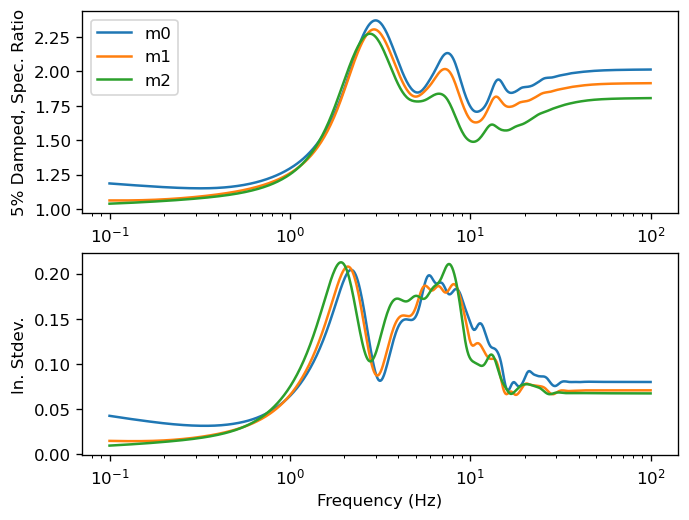

In [16]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;